In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
print(os.listdir("../model"))

['.ipynb_checkpoints', 'test1', 'train', '[cnn_cats_dogs].ipynb']


In [2]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
filenames = os.listdir("../train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head()

filename  category
0     cat.0.jpg         0
1     cat.1.jpg         0
2    cat.10.jpg         0
3   cat.100.jpg         0
4  cat.1000.jpg         0

In [5]:
df['category'].value_counts(normalize =  True)

category
0    0.5
1    0.5
Name: proportion, dtype: float64

In [6]:
df.tail()

filename  category
24995  dog.9995.jpg         1
24996  dog.9996.jpg         1
24997  dog.9997.jpg         1
24998  dog.9998.jpg         1
24999  dog.9999.jpg         1

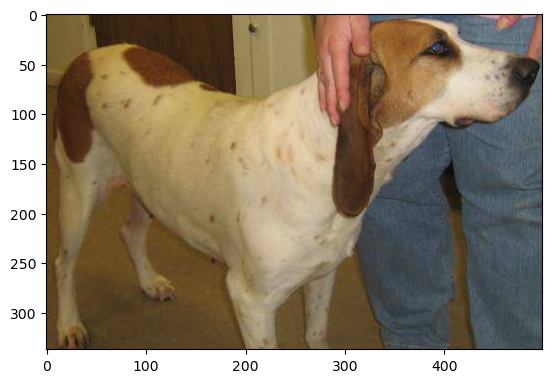

In [7]:
sample = random.choice(filenames)
image = load_img("train/"+sample)
plt.imshow(image)

# Build Model

In [8]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

In [9]:
earlystop = EarlyStopping(patience=10)

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            #min_lr=0.0001
                                           )

In [11]:
callbacks = [earlystop, 
             #learning_rate_reduction
            ]

In [12]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [13]:
df.shape

(25000, 2)

In [14]:
df["category"].value_counts()

category
cat    12500
dog    12500
Name: count, dtype: int64

In [15]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

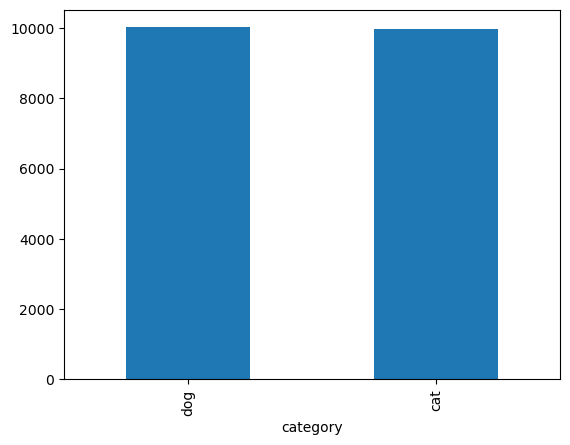

In [16]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

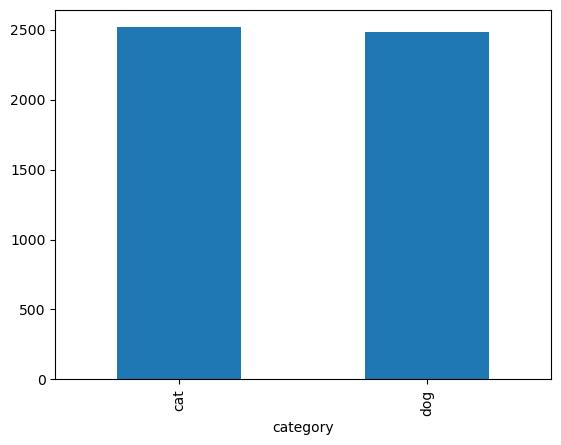

In [17]:
validate_df['category'].value_counts().plot.bar()

In [18]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Training Generator

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [20]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# Check

In [21]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


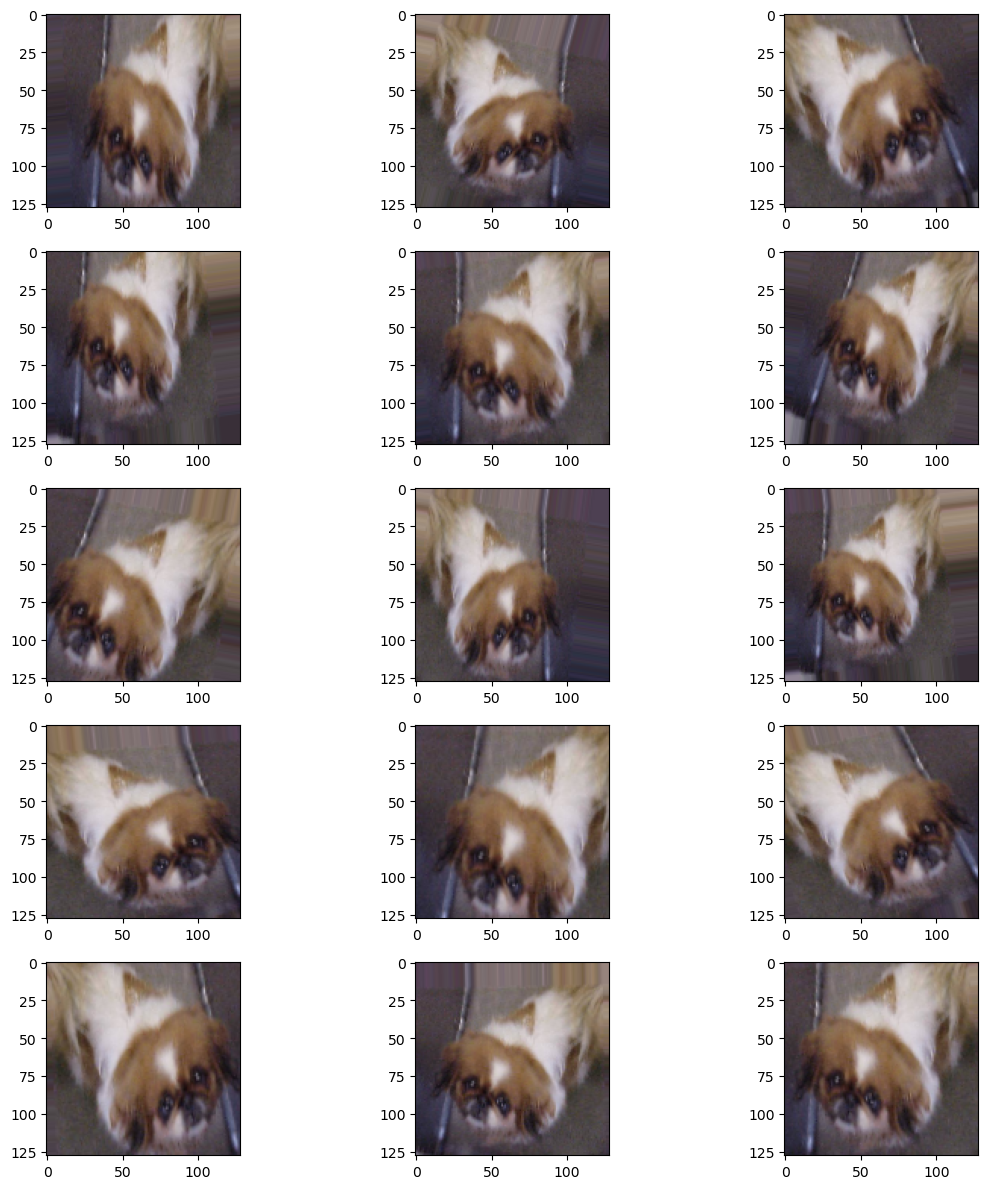

In [22]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model 

In [25]:
epochs=10 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1333/1333 [==============================] - 606s 455ms/step - loss: 0.4855 - accuracy: 0.7722 - val_loss: 0.7101 - val_accuracy: 0.7129
Epoch 2/10
1333/1333 [==============================] - 691s 518ms/step - loss: 0.4541 - accuracy: 0.7891 - val_loss: 0.5265 - val_accuracy: 0.7850
Epoch 3/10
1333/1333 [==============================] - 679s 509ms/step - loss: 0.4277 - accuracy: 0.8092 - val_loss: 0.3258 - val_accuracy: 0.8615
Epoch 4/10
1333/1333 [==============================] - 668s 501ms/step - loss: 0.4106 - accuracy: 0.8163 - val_loss: 0.3667 - val_accuracy: 0.8535
Epoch 5/10
1333/1333 [==============================] - 785s 589ms/step - loss: 0.3909 - accuracy: 0.8266 - val_loss: 0.4841 - val_accuracy: 0.7868
Epoch 6/10
1333/1333 [==============================] - 814s 610ms/step - loss: 0.3827 - accuracy: 0.8301 - val_loss: 0.4556 - val_accuracy: 0.8116
Epoch 7/10
1333/1333 [==============================] - 831s 623ms/step - loss: 0.3742 - accuracy: 0.8377 - val_

In [26]:
model.save_weights("model.h5")

In [28]:
history

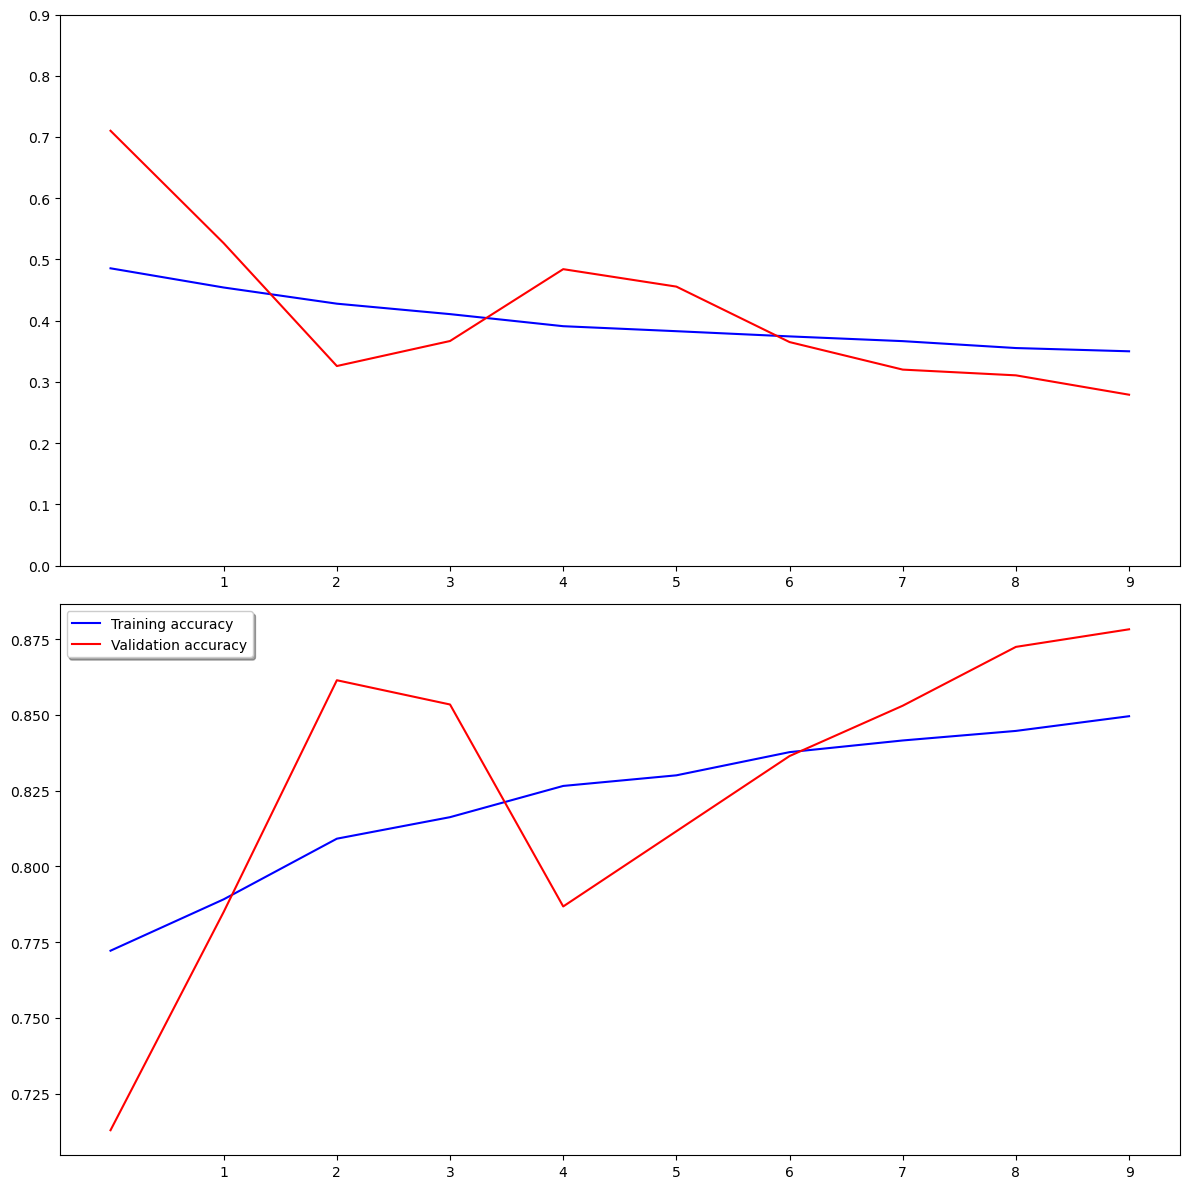

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [32]:
test_filenames = os.listdir("../test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [33]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [35]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

834/834 [==============================] - 155s 186ms/step


In [36]:
test_df['category'] = np.argmax(predict, axis=-1)

In [37]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [38]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

<Axes: xlabel='category'>

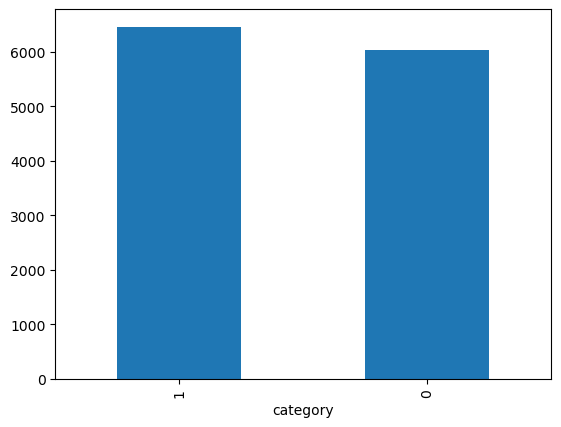

In [39]:
test_df['category'].value_counts().plot.bar()

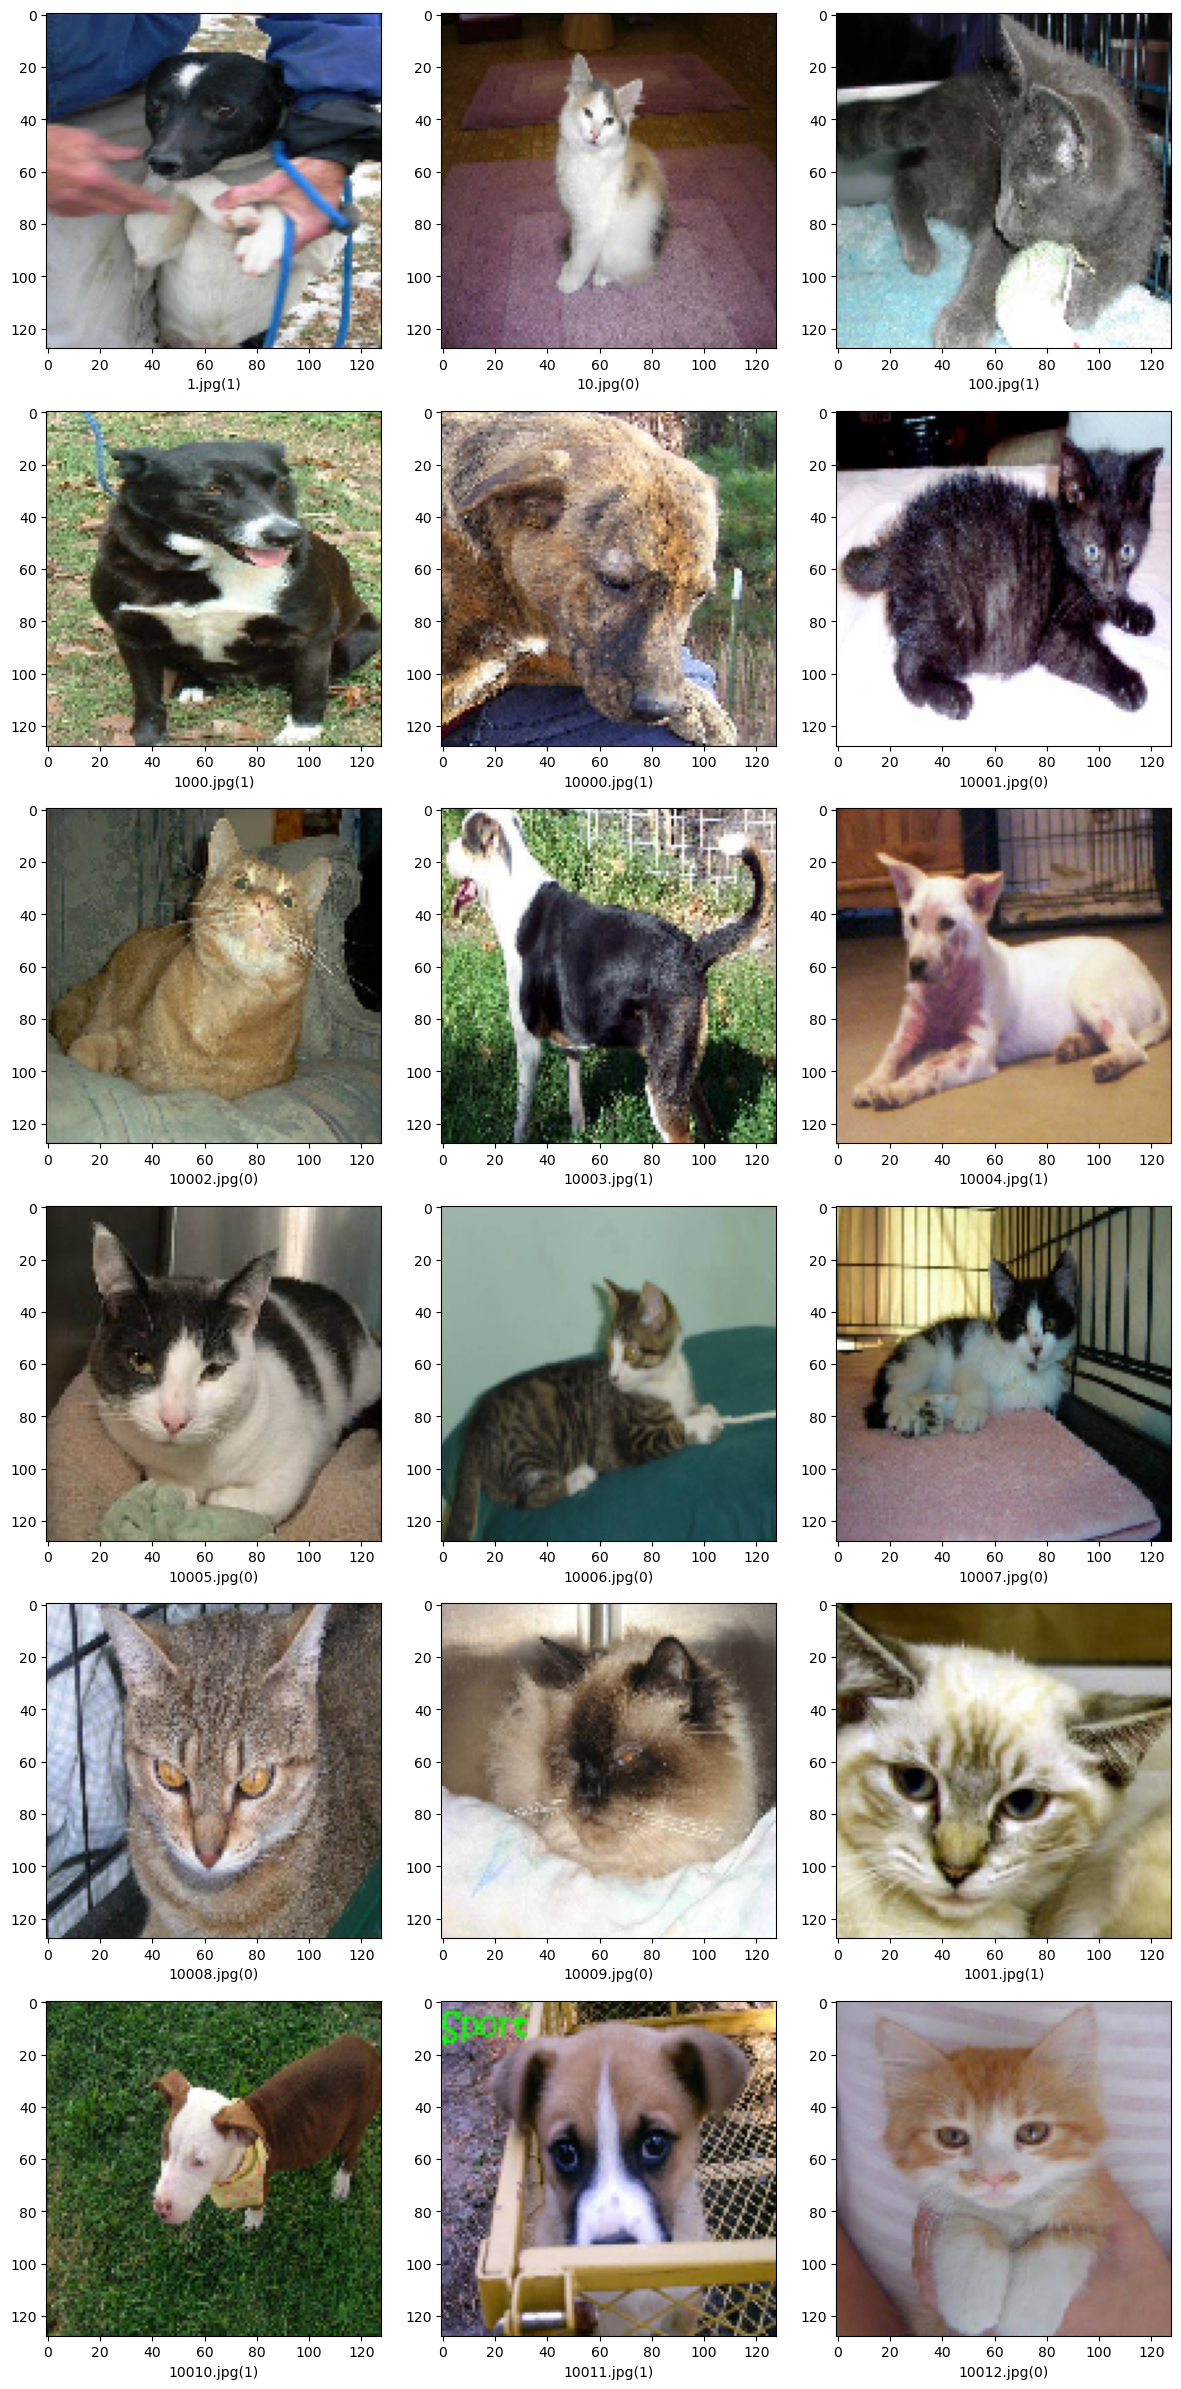

In [41]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()


In [42]:
y_pred = model.predict(validate_df)
y_pred_binary = (y_pred > 0.5).astype(int) 

#F1-score
f1 = f1_score(y_test, y_pred_binary, average = 'weighted')

#AUC
auc_roc = roc_auc_score(y_test, y_pred)

print("F1-Score:", f1)
print("AUC ROC:", auc_roc)

NameError: name 'X_test' is not defined

In [43]:
train_df.head()

filename category
0   dog.8479.jpg      dog
1    dog.876.jpg      dog
2  cat.10915.jpg      cat
3  dog.10127.jpg      dog
4  cat.11377.jpg      cat